In [60]:
import csv
import cv2
import numpy as np

lines = []
with open("data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

correction_factor = 0.2
        
images = []
measurments = []
for line in lines:
    source_path = line[0] # 0 index is for the center camera
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filename
    #print(current_path)
    image = cv2.imread(current_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
    images.append(image)

    # Add the measurement for the given image
    measurments.append(float(line[3]))

In [73]:
# Augment data
aug_images = []
aug_measurments = []

for image, measurment in zip(images, measurments):
    aug_images.append(image)
    aug_measurments.append(measurment)
    aug_images.append(cv2.flip(image, flipCode=1))
    aug_measurments.append(-measurment)

In [74]:
X_train = np.array(aug_images)
y_train = np.array(aug_measurments)

print("Number of training examples =", len(X_train))

Number of training examples = 4032


(160, 320, 3)


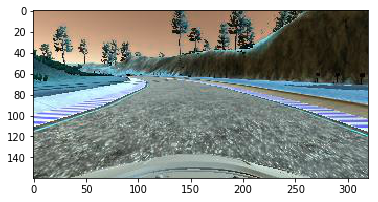

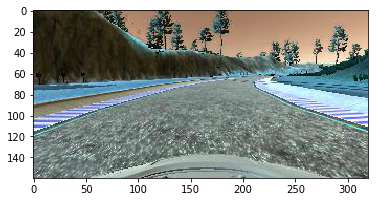

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

image_normal = X_train[0]
image_aug = X_train[1]

plt.figure(1)
plt.imshow(image_normal, cmap="gray")

plt.figure(2)
plt.imshow(image_aug, cmap="gray")

print(image_normal.shape)

In [80]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# model = Sequential()
# model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
# model.add(Flatten())
# model.add(Dense(1))

# LeNet
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model.h5')

Train on 3225 samples, validate on 807 samples
Epoch 1/5
 256/3225 [=>............................] - ETA: 137s - loss: 57.8215 - acc: 0.0781

KeyboardInterrupt: 